# TODO / Commentaire
 - Est ce qu'on met en log les births ?
 - 
 
 use of contraceptive method
 abortion
 impact of emmigration
 children as workpower

# Wesh les reufs bien ou quoi

Importing data:
 - `valeurs_mensuelles.csv`: containing the number of birth in France for each month from 01-01-2004 to 01-10-2020.<br>
 Columns:
     - Période: month
     - Démographie - Nombre de naissances vivantes - France métropolitaine: number of birth for the corresponding month
     - Codes: Codes for explaining what type of value we have in our case we have "P" for 2020 data standing for "provisional" and "A" everywhere else standing for normale value. (see `caract.csv` for further details)
 - `GTD.csv`: containing the query number of google trend data for different categories.<br>
   This dataframe is created in the notebook `GTD_preprocessing.ipynb`.<br>
 Columns:
     - date: date of the query number
     - category id : columns containing all the query number in France for this category.
     
 - `categories.csv`: containing all the ids and names of the google trend categories<br>
   This dataframe is created in the notebook `GTD_preprocessing.ipynb`. The categories can be seen as a list with sub-categories here: https://github.com/pat310/google-trends-api/wiki/Google-Trends-Categories<br>
 Columns:
     - id: id of the diffrent category
     - name: Name of this category

In [1]:
#***Attention***  les donnees n'ont pas les memes tailles
#valeurs mensuelle = 202x1        01-01-2004  --> 01-10-2020 
#GTD               = 204×916      01-01-2004  --> 01-12-2020       916 categories       (donnée incomplete pour decembre)    (certaines categories ne donne pas de resultat exemple : category 42 "jazz" https://trends.google.com/trends/explore?cat=42&date=all&geo=FR )
# categories       = 1133x3                                       1133 categories       (il y a bien 1133 category differentes sur google trend mais dans GTD on a enlevé les category sans resultat  il en reste 916)

In [2]:
# Clear all variables
#%reset -f

# Importing librairies: numpy, matplotlib, pandas, statmodel
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.regression.rolling import RollingOLS

In [3]:
# Importing birth data with selecting correct columns and changing columns names
data_folder = './Data/'
birth_df = pd.read_csv(data_folder +'valeurs_mensuelles.csv', sep= ';', index_col= 0, skiprows=2, usecols=[0,1],header=0, names=['Période','births'])

# Changing indexes to panda date
birth_df.index = pd.to_datetime(birth_df.index)

# Putting sales data in log scale as we want
birth_df['births'] = birth_df['births'].apply(np.log)

# Getting an overview
birth_df = birth_df.sort_index()
birth_df

,births
Période,
2004-01-01,11.067248
2004-02-01,10.989048
2004-03-01,11.018383
2004-04-01,11.020529
2004-05-01,11.026028
...,...
2020-06-01,10.978490
2020-07-01,11.044521
2020-08-01,11.008744


In [4]:
# Importing google trend data
from numpy import linalg as LA
GTD_df = pd.read_csv(data_folder +'GTD.csv',index_col= 0)

# Getting an overview
GTD_df = GTD_df.loc['2004-01-01':'2020-10-01']
col = pd.to_numeric(GTD_df.columns)
GTD_df

,0,3,5,7,8,11,12,13,14,16,...,1381,1385,1386,1387,1388,1389,1390,1391,1392,1397
date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,100,53,89,54,46,50,74,60,78,43,...,4,67,41,19,29,30,58,84,73,31
2004-02-01,75,53,84,55,46,47,74,55,72,40,...,4,100,52,38,72,60,85,81,92,26
2004-03-01,68,55,85,62,45,50,77,59,77,45,...,2,51,51,21,66,37,39,82,71,26
2004-04-01,56,56,85,59,48,54,78,55,76,43,...,3,88,89,33,76,75,56,78,98,26
2004-05-01,75,56,86,50,47,54,75,59,76,45,...,3,14,51,23,45,59,100,70,78,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-01,56,33,21,67,24,94,63,29,60,62,...,34,14,21,15,31,32,76,46,13,11
2020-07-01,47,31,19,60,23,83,57,27,57,53,...,31,12,15,11,40,35,76,45,21,8
2020-08-01,44,33,18,53,24,81,54,25,55,58,...,31,9,12,9,23,34,79,50,20,9


In [5]:
# Importing google trend categories
categories_df = pd.read_csv(data_folder +'categories.csv',index_col= 0)

# Keeping only the elements of interest and getting an overview
categories_df = categories_df[categories_df['id'].isin(col)]
categories_df

,id,name
1426,0,Toutes catégories
240,3,Arts et divertissements
715,5,Informatique et électronique
396,7,Finance
785,8,Jeux
...,...,...
1415,1389,Agritourisme
1418,1390,Visites touristiques
1417,1391,Oenotourisme
1412,1392,Offices du tourisme et syndicats d'initiative


In [6]:
#Standardize google trend data

mean_x = np.mean(GTD_df)
std_x = np.std(GTD_df)
x = GTD_df
x = x - mean_x
for i in range (len(std_x)):
    if std_x[i] == 0:
        std_x[i]=1
x = x / std_x
GTD_df = x
GTD_df

,0,3,5,7,8,11,12,13,14,16,...,1381,1385,1386,1387,1388,1389,1390,1391,1392,1397
date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,5.249401,-0.286742,1.946000,-1.837663,-0.099506,-2.317342,0.415269,-0.039441,0.549825,-1.000649,...,-1.039552,2.105135,0.870921,0.312119,-0.637383,-0.615030,-0.842779,1.832274,1.631805,0.049782
2004-02-01,2.377302,-0.286742,1.734501,-1.736351,-0.099506,-2.694034,0.415269,-0.272394,0.083493,-1.295731,...,-1.039552,3.883694,1.687456,2.399076,1.952096,1.302193,1.318254,1.650784,2.426081,-0.210737
2004-03-01,1.573114,-0.167806,1.776801,-1.027165,-0.146800,-2.317342,0.643629,-0.086031,0.472103,-0.803928,...,-1.119003,1.242803,1.613226,0.531799,1.590774,-0.167678,-2.363506,1.711280,1.548197,-0.210737
2004-04-01,0.194507,-0.108338,1.776801,-1.331102,-0.004917,-1.815085,0.719749,-0.272394,0.394381,-1.000649,...,-1.079277,3.236945,4.433983,1.849877,2.192978,2.260804,-1.002856,1.469293,2.676905,-0.210737
2004-05-01,2.377302,-0.108338,1.819101,-2.242912,-0.052211,-1.815085,0.491389,-0.086031,0.394381,-0.803928,...,-1.079277,-0.751338,1.613226,0.751479,0.326144,1.238285,2.518828,0.985319,1.840825,0.310302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-01,0.194507,-1.476101,-0.930386,-0.520604,-1.139985,3.207479,-0.422052,-1.483749,-0.849169,0.868203,...,0.152216,-0.751338,-0.613687,-0.127240,-0.516942,-0.487215,0.597910,-0.466604,-0.876435,-0.992295
2020-07-01,-0.839449,-1.595037,-1.014986,-1.229790,-1.187279,1.826274,-0.878772,-1.576930,-1.082335,-0.017043,...,0.033039,-0.859130,-1.059070,-0.566600,0.025042,-0.295493,0.597910,-0.527101,-0.542003,-1.148607
2020-08-01,-1.184101,-1.476101,-1.057286,-1.938975,-1.139985,1.575146,-1.107132,-1.670111,-1.237779,0.474761,...,0.033039,-1.020817,-1.281761,-0.786279,-0.998705,-0.359400,0.838024,-0.224617,-0.583807,-1.096503


## Analyse des categories

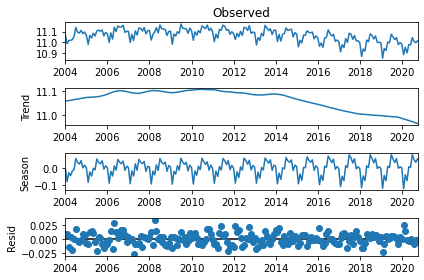

In [7]:
from statsmodels.tsa.seasonal import STL
#Checking seasonality
birth = STL(birth_df).fit()
birth.plot()
plt.show()

In [8]:
#Feature selection based on correlation on the ENTIRE DATASET

pearson = []
kendall = []
spearman = []
temp_df=pd.DataFrame(GTD_df.loc['2004-01-01':'2020-10-01'], dtype='float') #Taking the time index that are also in the birth_df

for i,j in enumerate(categories_df['id']):
    
    if str(j) in temp_df.columns:
        #Pearson correlation calculation
        pearsonTemp = np.abs(birth_df.iloc[:,0].corr(temp_df[str(j)],method='pearson'))
        pearson.append(pearsonTemp)
        #Kendall correlation calculation
        kendallTemp = np.abs(birth_df.iloc[:,0].corr(temp_df[str(j)],method='kendall'))       
        kendall.append(kendallTemp)
        #Spearman correlation calculation
        spearmanTemp = np.abs(birth_df.iloc[:,0].corr(temp_df[str(j)],method='spearman'))
        spearman.append(spearmanTemp)
        
    else:
        pearson.append(np.nan)
        kendall.append(np.nan)
        spearman.append(np.nan)

#Normalizing our correlation indicators in order to combine them
pearsonNorm = 100 / np.nanmax(pearson)
categories_df['Pearson'] = np.multiply(pearsonNorm, pearson)
kendallNorm = 100 / np.nanmax(kendall)    
categories_df['Kendall'] = np.multiply(kendallNorm, kendall)
spearmanNorm = 100 / np.nanmax(spearman)
categories_df['Spearman'] = np.multiply(spearmanNorm, spearman)

#Crossing between our correlations to see which feature is the best
cal = pd.DataFrame([categories_df["Spearman"], categories_df["Pearson"], categories_df["Kendall"]]).transpose()
cal = cal.mean(axis=1)
categories_df['Mean'] = cal

#Displaying the 10 best
categories_best = categories_df.sort_values('Mean', ascending=False).iloc[0:20,:].reset_index(drop=True)
categories_best

,id,name,Pearson,Kendall,Spearman,Mean
0,1211,ORL,100.000000,94.823018,93.763942,96.195653
1,1253,Actualités de la santé,83.949198,100.000000,100.000000,94.649733
2,1238,Nettoyage du corps et désintoxication,98.979640,90.929204,91.393587,93.767477
3,1256,Politique sanitaire,81.018001,96.940508,97.343253,91.767254
4,645,Pédiatrie,94.640563,89.961860,89.851515,91.484646
5,245,Soins bucco-dentaires,94.063873,89.651974,90.486631,91.400826
6,689,Surf et natation,88.637512,88.975573,91.245771,89.619619
7,708,Bus et trains,83.904935,89.038839,91.641572,88.195115
8,638,RGO et troubles digestifs,86.950219,88.575575,88.552534,88.026109
9,557,Massothérapie,91.360000,84.475794,86.493303,87.443032


## Feature selection

We can see that the feature with the highest correlation are: 

In [9]:
 k = 6
    
#size of the rolling window = 17 = 4 mois ds le précédent paper, on prend 6 dans celui là comme en plus on a une saisonnalité de 6 mois
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5269518/

In [10]:
#Feature selection based on improvement in ['2014-01-01':'2020-10-01']

improvement = []

#Checking for each feature
for i in (GTD_df.columns):
    
    #Setting the dfs
    df = pd.DataFrame()
    df['birth'] = birth_df.births
    nan = np.empty(6)
    nan[:] = 0
    df['birth_6'] =  [*nan , *birth_df.births[:-6].values] # Moving down 6 rows and putting 0 in the empty space
    nan = np.empty(12)
    nan[:] = 0
    df['birth_12'] =  [*nan , *birth_df.births[:-12].values] # Moving down 12 rows and putting 0 in the empty space    
   
    #Setting the feature of interest
    df[str("y0")] = GTD_df[str(i)]
    df = df.loc['2004-01-01':'2020-10-01']
    df = df.reset_index(drop=True) #Resetting the index to [0-n] format
    
    #Basic reg
    res_base = RollingOLS.from_formula('birth ~ birth_6 + birth_12', data=df, window=k).fit() #We use our rolling windows function
    params = pd.DataFrame(res_base.params.shift(periods=1, axis=0)) #we shift the output parameters one row down in order to apply to the next mont (predict)
    params.columns = ['a0','a1','a2'] #Changing the parameters' columns names
    df = pd.concat([df, params], axis=1) #adding it to our dataframe
    df['predict_base'] = df.a0 + df.a1*df.birth_6 + df.a2*df.birth_12 #predicting the values for the next month

    #Trend reg with feature of interest
    res_trend = RollingOLS.from_formula('birth ~ birth_6 + birth_12 + y0', data=df, window=17).fit()#We use our rolling windows function
    params = pd.DataFrame(res_trend.params.shift(periods=1, axis=0)) #we shift the output parameters one row down in order to apply to the next mont (predict)
    params.columns = ['b0','b1','b2','b3']#Changing the parameters' columns names
    df = pd.concat([df, params], axis=1) #adding it to our dataframe
    df['predict_trend'] = df.b0 + df.b1*df.birth_6 + df.b2*df.birth_12 + df.b3 * df.y0   #predicting the values for the next month
    
    #Calculating MAE and Improvement
    mae_base = np.mean(abs(df.birth-df.predict_base))*100
    mae_trends = np.mean(abs(df.birth-df.predict_trend))*100
    improvement_overall = (mae_base-mae_trends)*100 /mae_base
    improvement.append(improvement_overall)

In [11]:
#Improvement for each topic
improvement

[7.737044402036288,
 7.730888209209548,
 6.972782530796106,
 7.295194742501069,
 6.5971589551859475,
 6.661995378463539,
 7.121865145201213,
 7.375558275120353,
 6.604177922255,
 3.575359080329023,
 8.609901193829838,
 8.849655202583829,
 7.2065614631900425,
 7.901843170356319,
 8.2942330998409,
 6.010103710641429,
 8.434626121076649,
 9.69280699232857,
 6.470572125986909,
 7.201331135735115,
 5.895245588586057,
 6.924019776904529,
 8.100383187353021,
 9.491903375113154,
 5.572530456158717,
 5.345217897352083,
 10.027747263559533,
 8.564684655864218,
 3.624622181506522,
 6.510353740418946,
 7.735473527412917,
 7.851134543573389,
 7.713660078162942,
 9.364602338920092,
 6.3130357270345625,
 10.212254297666203,
 6.9166367057559315,
 8.345030035689215,
 8.945497195214754,
 7.570607943496152,
 11.556492376226046,
 10.441089428043192,
 7.863823290216285,
 8.053575337854515,
 8.85476603418522,
 3.04271208238057,
 6.414053789405659,
 5.505346237759714,
 6.237718619427412,
 7.596226399345266,


In [12]:
#Our df well ordered
categories_best = categories_df.reset_index(drop=True)

In [13]:
categories_best['Improvement'] = pd.DataFrame(improvement)
categories_best = categories_best.sort_values('Improvement', ascending=False)
categories_best = categories_best.reset_index(drop=True)
categories_best.head(10)

,id,name,Pearson,Kendall,Spearman,Mean,Improvement
0,1304,Éthique-,36.550469,31.120724,33.512455,33.727882,14.390468
1,1293,Gros électroménager,35.999647,27.470997,32.519325,31.996656,13.002803
2,102,Petites annonces pour rencontres,80.065222,75.784026,79.235499,78.361582,12.971499
3,869,Judaïsme,35.257634,28.290083,34.373020,32.640246,12.911476
4,317,Dessins animés et mangas,74.790835,72.224107,77.239712,74.751551,12.774002
5,1068,Rolls-Royce,28.913908,35.724394,38.765519,34.467940,12.756196
6,554,Sports extrêmes,57.624209,71.259292,74.970797,67.951433,12.609890
7,811,Cartes de paiement,27.235934,19.130473,19.889104,22.085170,12.549422
8,1296,Lieux de culte,46.069981,56.764407,59.383911,54.072766,12.450458
9,1350,Traitement de l'alcoolisme et de la toxicomanie,18.241096,20.019163,22.065869,20.108710,12.258823


In [14]:
df = pd.DataFrame()
temp_df=pd.DataFrame(GTD_df, dtype='float')

#Birth_df Data
df['birth'] = birth_df.births
nan = np.empty(6)
nan[:] = 0
df['birth_6'] =  [*nan , *birth_df.births[:-6].values] # Moving down 6 rows and putting 0 in the empty space
nan = np.empty(12)
nan[:] = 0
df['birth_12'] =  [*nan , *birth_df.births[:-12].values] # Moving down 12 rows and putting 0 in the empty space

#Features selection
for i in range (20):
    df[str("y{}".format(categories_best.index[i]))] = temp_df.loc[:,str(categories_best.id[i])]
    #GTD_df.loc[:,str(categories_best.id[i])]
    
index_date = df.index #saving the index for later plotting
df = df.loc['2004-01-01':'2020-10-01']
df = df.reset_index(drop=True) #Resetting the index to [0-n] format


res_base = RollingOLS.from_formula('birth ~ birth_6 + birth_12', data=df, window=k).fit() #We use our rolling windows function
params = pd.DataFrame(res_base.params.shift(periods=1, axis=0)) #we shift the output parameters one row down in order to apply to the next mont (predict)
params.columns = ['a0','a1','a2'] #Changing the parameters' columns names
df = pd.concat([df, params], axis=1) #adding it to our dataframe
df['predict_base'] = df.a0 + df.a1*df.birth_6 + df.a2*df.birth_12 #predicting the values for the next month

res_trend = RollingOLS.from_formula('birth ~ birth_6 + birth_12 + y0', data=df, window=17).fit()#We use our rolling windows function
params = pd.DataFrame(res_trend.params.shift(periods=1, axis=0)) #we shift the output parameters one row down in order to apply to the next mont (predict)
params.columns = ['b0','b1','b2','b3']#Changing the parameters' columns names
df = pd.concat([df, params], axis=1) #adding it to our dataframe
df['predict_trend'] = df.b0 + df.b1*df.birth_6 + df.b2*df.birth_12 + df.b3 * df.y0  #predicting the values for the next month

#MAE + Improvement overall calculation between the base fit and base+trend fit
mae_base = np.mean(abs(df.birth-df.predict_base))*100
mae_trends = np.mean(abs(df.birth-df.predict_trend))*100
improvement_overall = (mae_base-mae_trends)*100 /mae_base
improvement_overall

14.390468192375284

<function matplotlib.pyplot.show(close=None, block=None)>

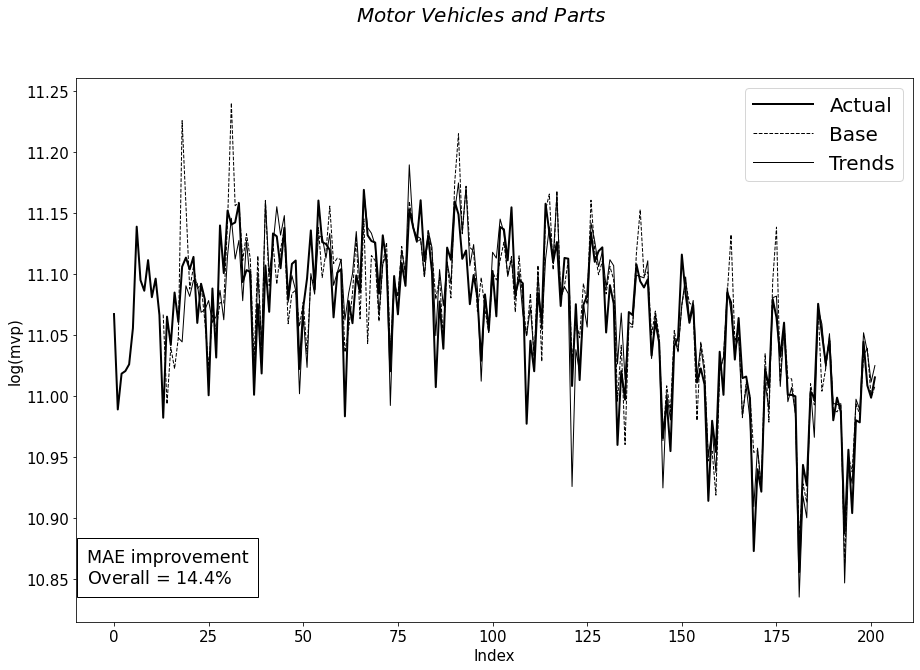

In [15]:


#Defining the overall parameters for the figure
params = {'legend.fontsize': 20,
          'legend.handlelength': 3,
          'figure.figsize': (15,10),
          'axes.labelsize' : 15,
          'xtick.labelsize' : 15,
          'ytick.labelsize' : 15}
plt.rcParams.update(params) #applying them

#plotting each curve with specific parameters
fig, ax = plt.subplots()
ax.plot(df.birth, 'k', linewidth=2, label='Actual') #Thicker line for the real data
ax.plot(df.predict_base, 'k--', linewidth=1,label='Base') #Doted line for the predicted curve with basic data
ax.plot(df.predict_trend, 'k', linewidth=1, label='Trends') #Classic line for the predicted curve with basic + trend data

#Defining figure title
plt.suptitle('$Motor$ $Vehicles$ $and$ $Parts$', fontsize=20)

#Defining (x;y) labels
plt.xlabel('Index')
plt.ylabel('log(mvp)')

#Plotting the legend
plt.legend(loc="upper right")

#Creating the box with the MAE improvements
textstr = '\n'.join((
    r'MAE improvement',
    r'Overall = $%.1f$%%' % (improvement_overall, )))
ax.text(0.013, 0.135, textstr, transform=ax.transAxes, fontsize=17.5,
        verticalalignment='top', bbox=dict(facecolor='none', edgecolor='black', pad=10))

#Showing the plot
plt.show